#### Imports para entrenamiento, predicción y evaluación del modelo ####


In [1]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('darkgrid')

In [2]:
data_file_path = '/home/mgarcia/Documents/Study/DiploDatos/Exercises/Integrators/Integrator_1/data.csv'
tag_file_path = '/home/mgarcia/Documents/Study/DiploDatos/Exercises/Integrators/Integrator_1/tag.csv'

In [3]:
data = pd.read_csv(data_file_path)
tag = pd.read_csv(tag_file_path)

In [4]:
traffic_columns = [traffic_column for traffic_column in data.columns if traffic_column.startswith("TR")]

In [5]:
len(traffic_columns)

33

#### Data frame solo con datos de tráfico

In [6]:
df_traffic = data[traffic_columns]
del data  # libero memoria

In [7]:
df_traffic.head()

,TRD_M1,TRD_M2,TRD_M3,TRD_STR_M1,TRD_STR_M2,TRD_STR_M3,TRD_SN_M1,TRD_SN_M2,TRD_SN_M3,TRD_IM_M1,...,TRV_ONNET_DUR_M3,TRV_OFFNET_DUR_M1,TRV_OFFNET_DUR_M2,TRV_OFFNET_DUR_M3,TRV_LCL_DUR_M1,TRV_LCL_DUR_M2,TRV_LCL_DUR_M3,TRV_INTRNTL_DUR_M1,TRV_INTRNTL_DUR_M2,TRV_INTRNTL_DUR_M3
0,15.09,5.06,1.00,12538,1121,866,0,38,0,526,...,1.67,8.33,21.95,1.13,147.87,210.55,2.80,0.0,0.0,0.0
1,0.00,0.00,0.00,0,0,0,0,0,0,0,...,0.00,2.27,4.12,0.62,2.27,4.12,0.62,0.0,0.0,0.0
2,0.42,0.00,0.09,57,0,0,0,0,0,244,...,0.68,8.00,3.28,0.20,9.38,3.28,0.88,0.0,0.0,0.0
3,0.14,0.00,0.00,7,0,0,65,0,0,54,...,0.00,0.00,0.00,0.00,1.17,0.00,0.00,0.0,0.0,0.0
4,1.80,3.90,0.88,667,2078,83,128,110,9,562,...,12.05,0.00,0.08,0.00,0.00,0.08,12.05,0.0,0.0,0.0


#### Corroborar si algun datao es NaN o null

In [8]:
any(df_traffic.isna().sum() != 0) or any(df_traffic.isnull().sum() != 0)

False

# Selección de columnas

In [9]:
df_traffic.corr()

,TRD_M1,TRD_M2,TRD_M3,TRD_STR_M1,TRD_STR_M2,TRD_STR_M3,TRD_SN_M1,TRD_SN_M2,TRD_SN_M3,TRD_IM_M1,...,TRV_ONNET_DUR_M3,TRV_OFFNET_DUR_M1,TRV_OFFNET_DUR_M2,TRV_OFFNET_DUR_M3,TRV_LCL_DUR_M1,TRV_LCL_DUR_M2,TRV_LCL_DUR_M3,TRV_INTRNTL_DUR_M1,TRV_INTRNTL_DUR_M2,TRV_INTRNTL_DUR_M3
TRD_M1,1.000000,0.819897,0.706444,0.880530,0.686740,0.589018,0.680411,0.576677,0.504866,0.593411,...,0.107154,0.134440,0.102743,0.077624,0.169570,0.137804,0.113377,-0.000773,-0.002232,-0.004701
TRD_M2,0.819897,1.000000,0.812299,0.704101,0.849376,0.686593,0.568637,0.671875,0.563763,0.512410,...,0.121957,0.113338,0.122002,0.090125,0.141943,0.161491,0.129081,-0.000854,0.001362,-0.001865
TRD_M3,0.706444,0.812299,1.000000,0.602125,0.678701,0.877616,0.503848,0.570486,0.665991,0.457710,...,0.147253,0.094316,0.101494,0.105583,0.121747,0.138817,0.155561,-0.004722,-0.003314,-0.003169
TRD_STR_M1,0.880530,0.704101,0.602125,1.000000,0.764232,0.642544,0.371446,0.312305,0.267777,0.308190,...,0.086616,0.076968,0.058092,0.039714,0.129685,0.105906,0.089213,0.000450,0.000482,-0.001999
TRD_STR_M2,0.686740,0.849376,0.678701,0.764232,1.000000,0.751853,0.282610,0.333055,0.274304,0.254250,...,0.096966,0.056978,0.065639,0.042894,0.107090,0.121827,0.099642,-0.000372,0.002228,-0.000502
TRD_STR_M3,0.589018,0.686593,0.877616,0.642544,0.751853,1.000000,0.249587,0.284675,0.334460,0.220446,...,0.114020,0.043531,0.051642,0.053253,0.088952,0.102413,0.117524,-0.003120,-0.001942,-0.002279
TRD_SN_M1,0.680411,0.568637,0.503848,0.371446,0.282610,0.249587,1.000000,0.844782,0.749215,0.455462,...,0.035954,0.088585,0.066330,0.049818,0.073528,0.056111,0.040727,-0.005767,-0.007249,-0.007717
TRD_SN_M2,0.576677,0.671875,0.570486,0.312305,0.333055,0.284675,0.844782,1.000000,0.844078,0.403161,...,0.043548,0.076208,0.078627,0.058169,0.059258,0.068211,0.049022,-0.006036,-0.006423,-0.007252
TRD_SN_M3,0.504866,0.563763,0.665991,0.267777,0.274304,0.334460,0.749215,0.844078,1.000000,0.359763,...,0.051734,0.063119,0.064802,0.066499,0.044817,0.052227,0.057883,-0.006818,-0.007302,-0.006473
TRD_IM_M1,0.593411,0.512410,0.457710,0.308190,0.254250,0.220446,0.455462,0.403161,0.359763,1.000000,...,0.119294,0.159099,0.125445,0.102146,0.183313,0.153102,0.127902,-0.002409,-0.006056,-0.006909


Plotear un heatmap de 33x33 es inviable, vamos a separar por tipo de dato:
1. Tráfico de datos
   * Total
   * Streaming
   * Redes sociales
   * Internet
2. Número de SMS
3. Tiempo de llamadas de voz
Y cada uno de estos los vamos a agrupar por por mes, para evaluar la relación que hay entre un mismo tipo de consumo por mes.

## Tráfico de datos

#### Correlación de consumo de datos agrupados por tipo

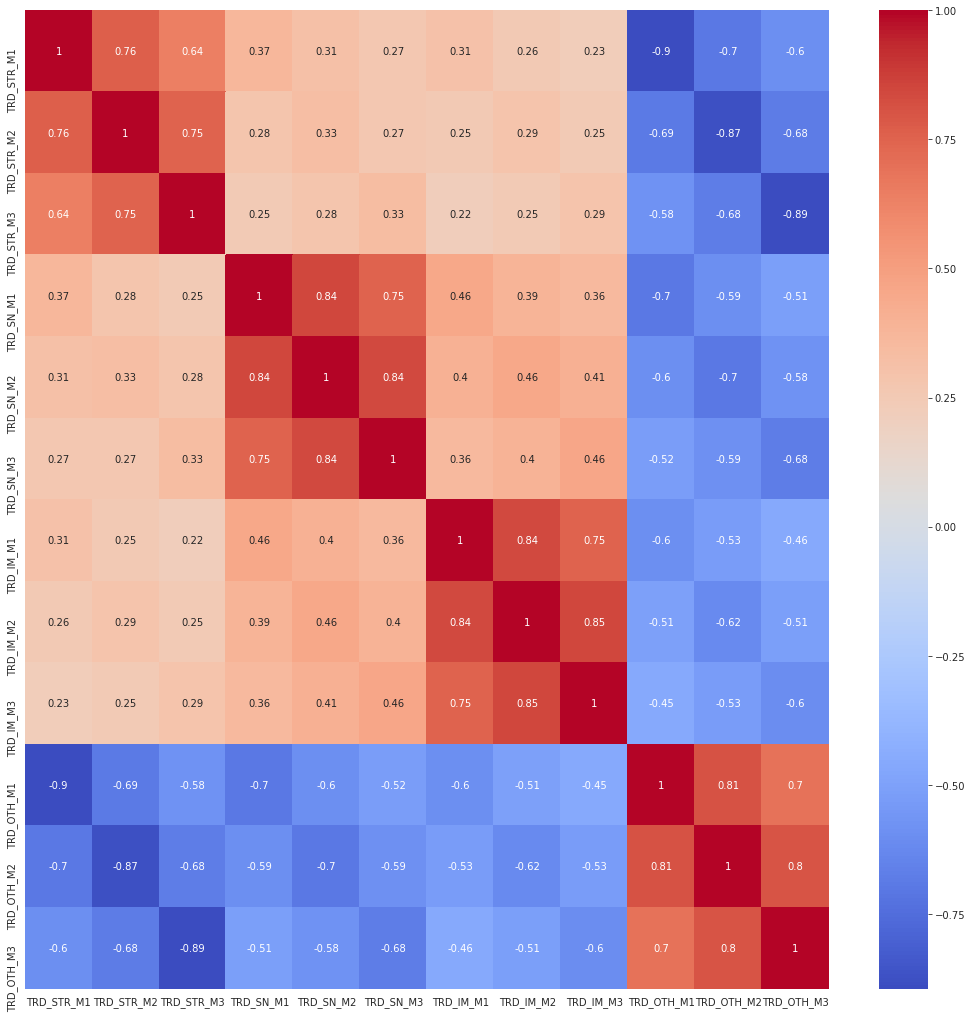

In [10]:
# FIXME: Corroborar que estas columnas tienen el total de los datos
total_data_columns = ['TRD_M1', 'TRD_M2', 'TRD_M3']
df_traffic_data_columns = [traffic_column for traffic_column in traffic_columns 
                           if traffic_column.startswith("TRD") 
                           and traffic_column not in  total_data_columns]
df_traffic_data_corr  = df_traffic[df_traffic_data_columns].corr()
# df_traffic_data_corr
plt.figure(figsize=(18, 18))
sns.heatmap(df_traffic_data_corr, annot=True, cmap='coolwarm')

Función que devuelve dos últimos elementos de iterable, en este caso mes de las columnas

In [11]:
get_month = lambda x: x[-2:]

#### Correlación de consumo de datos agrupados por mes

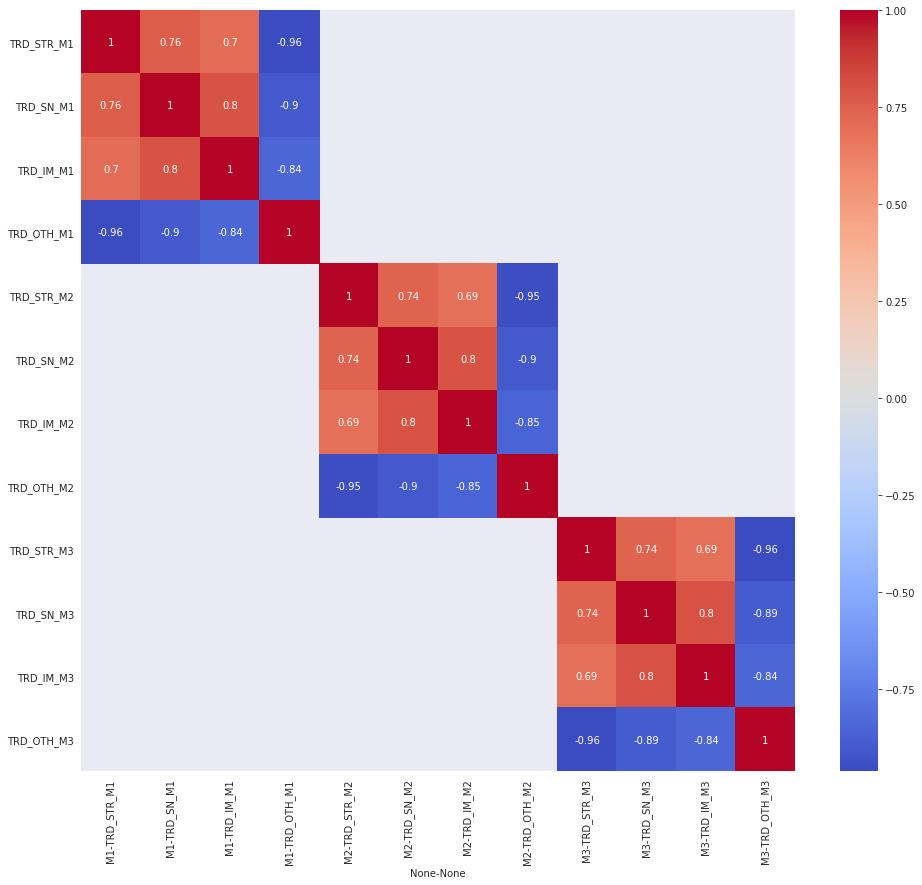

In [12]:
by_month_traffic_data_corr = df_traffic_data_corr.groupby(by=get_month, axis=1).corr()
# by_month_traffic_data_corr
plt.figure(figsize=(16, 14))
sns.heatmap(by_month_traffic_data_corr, annot=True, cmap='coolwarm')

#### Correlación entre número de SMS agrupados por tipo

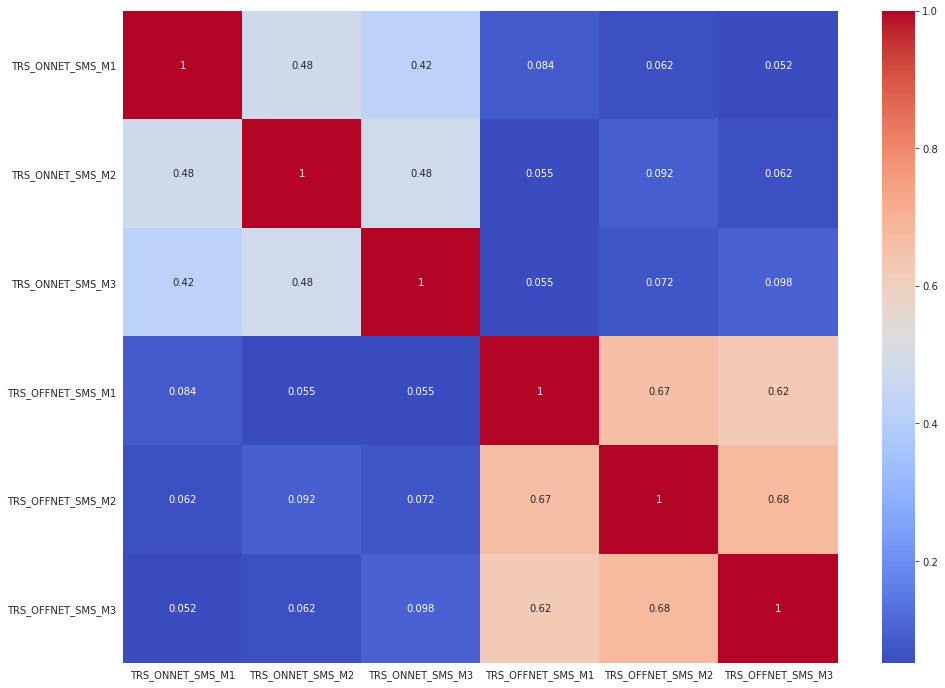

In [14]:
df_n_sms_columns = [traffic_column for traffic_column in traffic_columns if traffic_column.startswith("TRS")]
df_n_sms_corr  = df_traffic[df_n_sms_columns].corr()
# df_n_sms_corr
plt.figure(figsize=(16, 12))
sns.heatmap(df_n_sms_corr, annot=True, cmap='coolwarm')

#### Correlación entre número de SMS agrupados por mes

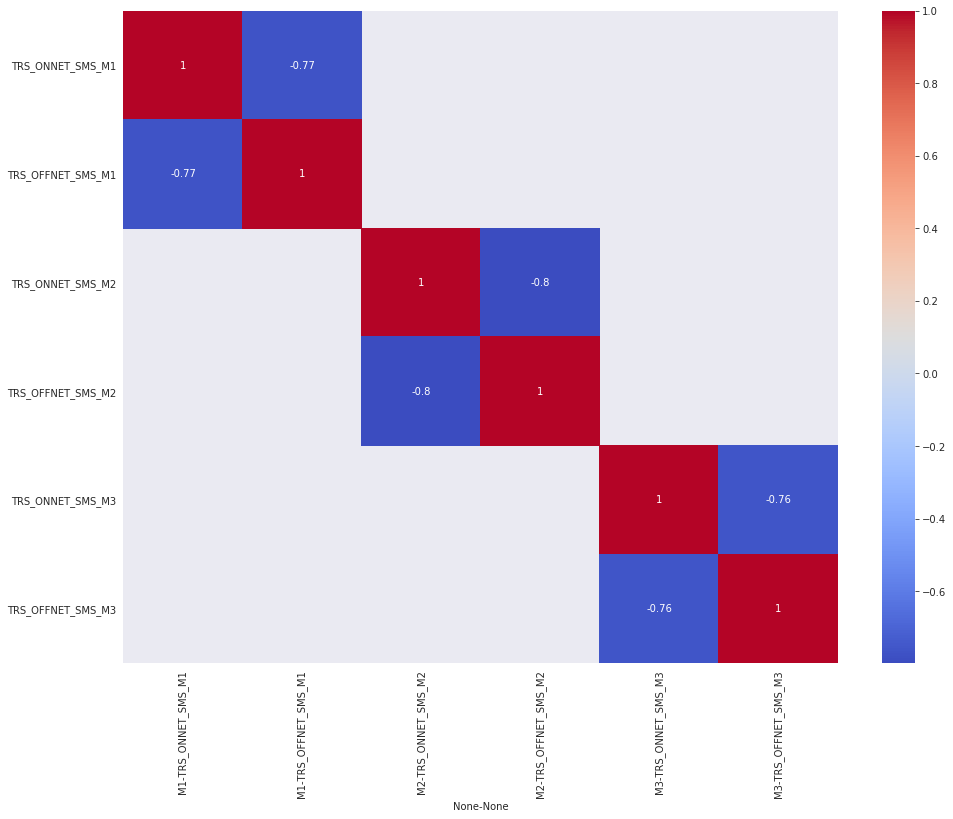

In [15]:
by_month_n_sms_corr = df_n_sms_corr.groupby(by=get_month, axis=1).corr()
# by_month_n_sms_corr
plt.figure(figsize=(16, 12))
sns.heatmap(by_month_n_sms_corr, annot=True, cmap='coolwarm')

#### Correlación de llamadas por voz agrupadas por tipo

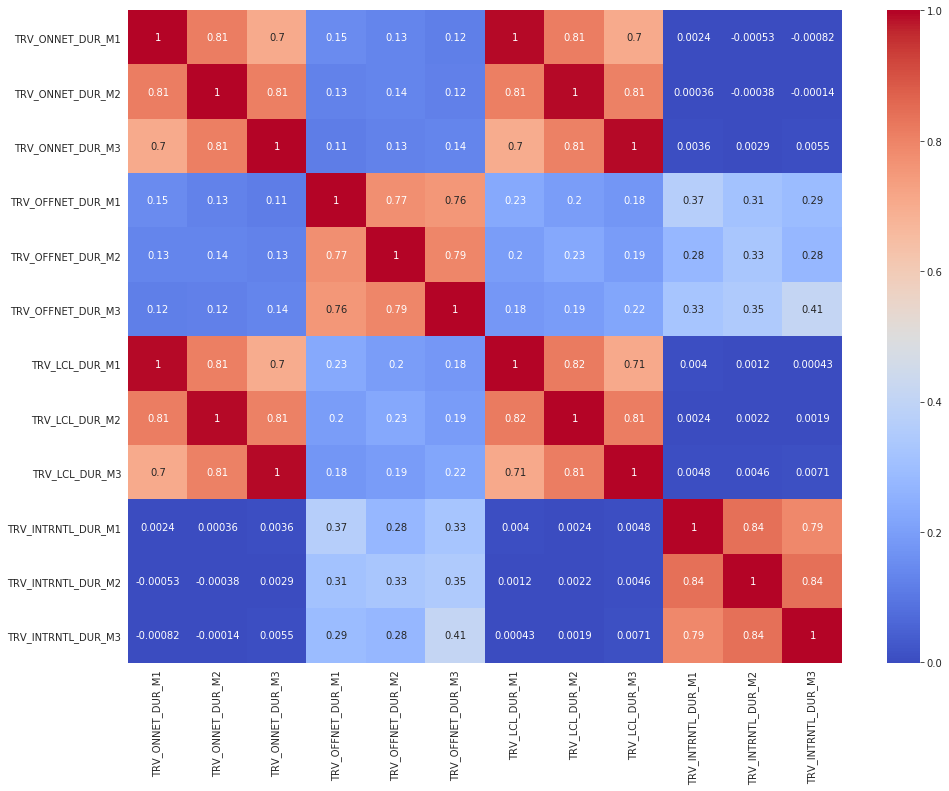

In [16]:
df_voice_minutes_columns = [traffic_column for traffic_column in traffic_columns if traffic_column.startswith("TRV")]
df_voice_minutes_corr = df_traffic[df_voice_minutes_columns].corr()
# df_n_sms_corr
plt.figure(figsize=(16, 12))
sns.heatmap(df_voice_minutes_corr, annot=True, cmap='coolwarm')

#### Correlación de llamadas por voz agrupadas por mes

In [ ]:
by_month_voice_minutes_corr = df_voice_minutes_corr.groupby(by=get_month, axis=1).corr()
# by_month_n_sms_corr
plt.figure(figsize=(16, 12))
sns.heatmap(by_month_voice_minutes_corr, annot=True, cmap='coolwarm')